# MindBridge: Connecting the Brain to ChatGPT
### Unified Cognitive–Emotional–BCI AI System

This notebook integrates three research streams:
1. **Cognitive-to-Linguistic Interface**  
2. **Emotionally Adaptive ChatGPT**  
3. **Brain-Controlled ChatGPT Interface**

We use EEG data from two datasets:
- PhysioNet EEG Motor/Imagery  [(Resource)](https://physionet.org/content/eegmmidb/1.0.0/?utm_source=chatgpt.com)
- EEG Emotion Classification Dataset  [(Resource)](https://zenodo.org/records/14787743?utm_source=chatgpt.com)

The system extracts EEG features, maps them to emotional/cognitive states, and dynamically adjusts ChatGPT prompts for context-aware, adaptive responses.

## Setup & Installation
In this cell, we install all dependencies required for EEG preprocessing, model building, and API integration.

In [ ]:
!pip install mne numpy pandas matplotlib scikit-learn tensorflow keras openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.7 MB/s eta 0:00:00


## Import All necessary Libraries
Import all key libraries for EEG data manipulation, visualization, and model building

In [ ]:
import numpy as np
import pandas as pd
import mne
import shutil
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import openai


## Upload DataSets and UnZip

In [21]:
# Define your zip file paths
physionet_zip = "/content/physionet.zip"
emotion_zip = "/content/eeg_emotions.zip"

# Define your target extraction directories
physionet_folder = "/content/data/physionet"
emotion_folder = "/content/data/emotion_eeg"

# Create directories if they don't exist
os.makedirs(physionet_folder, exist_ok=True)
os.makedirs(emotion_folder, exist_ok=True)

# --- Unzip PhysioNet dataset ---
shutil.unpack_archive(physionet_zip, physionet_folder)
print("✅ PhysioNet dataset unzipped successfully at:", physionet_folder)

# --- Unzip Emotion EEG dataset ---
shutil.unpack_archive(emotion_zip, emotion_folder)
print("✅ Emotion EEG dataset unzipped successfully at:", emotion_folder)


✅ PhysioNet dataset unzipped successfully at: /content/data/physionet
✅ Emotion EEG dataset unzipped successfully at: /content/data/emotion_eeg


## Load PhysioNet EEG Data
Load and visualize an EEG sample from PhysioNet.
This dataset will be used for cognitive and motor-intent decoding.

Loading EDF file: /content/data/physionet/files/S101/S101R06.edf
Extracting EDF parameters from /content/data/physionet/files/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False

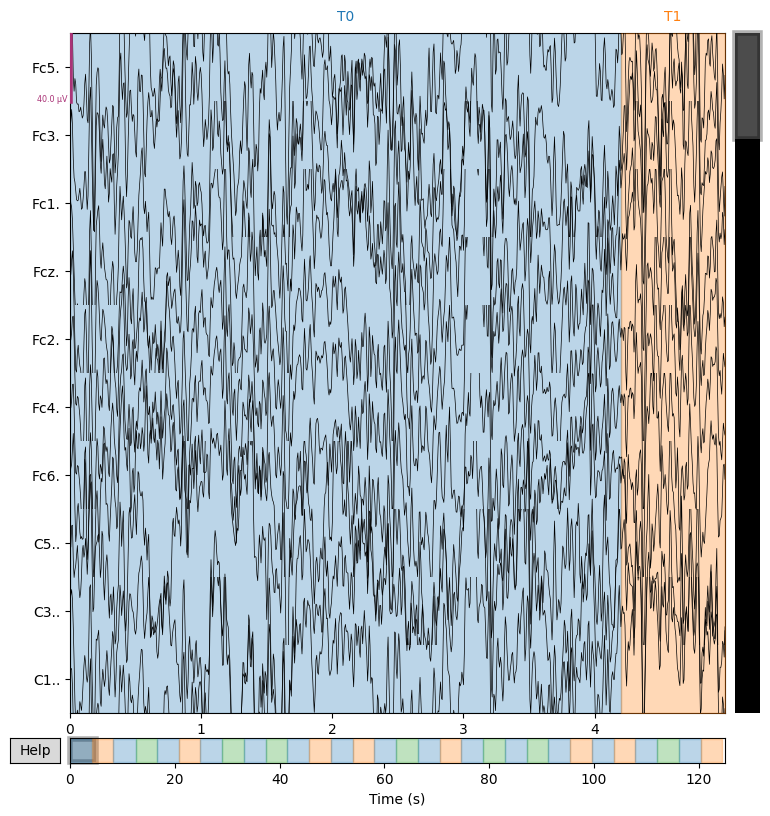

In [25]:
physionet_folder = "/content/data/physionet/files"

# Recursively find all .edf files
edf_files = []
for root, dirs, files in os.walk(physionet_folder):
    for f in files:
        if f.endswith(".edf"):
            edf_files.append(os.path.join(root, f))

# Check if any EDF files were found
if edf_files:
    # For example, take the first one
    edf_file = edf_files[0]
    print("Loading EDF file:", edf_file)

    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.filter(0.5, 45)

    print(raw.info)
    raw.plot(duration=5, n_channels=10)
else:
    print("No .edf files found in the PhysioNet data directory.")


## Extract Cognitive Features
Convert EEG signals to frequency-domain features such as Power Spectral Density (PSD) and Differential Entropy (DE), which represent mental activity patterns.

In [32]:
import numpy as np
import mne

# Function to compute Hjorth parameters
def compute_hjorth_parameters(data):
    # data: np.array, shape = (n_channels, n_samples)
    activity = np.var(data, axis=1)
    mobility = np.sqrt(np.var(np.diff(data, axis=1), axis=1) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(data, axis=1), axis=1), axis=1) / np.var(np.diff(data, axis=1), axis=1))
    return np.stack([activity, mobility, complexity], axis=1)  # shape: (n_channels, 3)

# Full cognitive feature extraction function
def extract_cognitive_features(raw_eeg):
    """
    raw_eeg: mne.io.Raw object
    returns: np.array, shape = (n_channels, n_features)
    """
    # --- PSD Features (Frequency-domain) ---
    # Use MNE's compute_psd (Welch method)
    psd = raw_eeg.compute_psd(method='welch', fmin=0.5, fmax=45, n_fft=256)
    psd_data = psd.get_data()  # shape: (n_channels, n_freqs)
    psd_mean = np.mean(psd_data, axis=1)  # mean across frequencies -> shape: (n_channels,)

    # --- Hjorth Parameters (Time-domain) ---
    eeg_data = raw_eeg.get_data()  # shape: (n_channels, n_samples)
    hjorth = compute_hjorth_parameters(eeg_data)  # shape: (n_channels, 3)
    hjorth_flat = hjorth.reshape(hjorth.shape[0], -1)  # flatten to 2D array

    # --- Combine features ---
    cognitive_features = np.hstack([psd_mean.reshape(-1,1), hjorth_flat])  # shape: (n_channels, 4)
    return cognitive_features

# Example usage:
cognitive_features = extract_cognitive_features(raw)
print("Cognitive feature shape:", cognitive_features.shape)


Effective window size : 1.600 (s)
Cognitive feature shape: (64, 4)


## Load Emotion EEG Dataset
Now, we load the second dataset — EEG Emotion Classification (Biosemi or Muse2).
This dataset helps train the Emotionally Adaptive component.

If you check in the folders to the left, you will see that the EEG emotions files are put in a .rar folder, so we need to extract them first.

In [34]:
!pip install rarfile

In [38]:
import rarfile
import os

emotion_rar = "/content/data/emotion_eeg/Comparativa EEG-BCI.rar"
emotion_folder = "/content/data/emotion_eeg/extracted"

# Create folder to extract
os.makedirs(emotion_folder, exist_ok=True)

# Extract all files
with rarfile.RarFile(emotion_rar) as rf:
    rf.extractall(emotion_folder)

print("Extraction completed. Files:", os.listdir(emotion_folder))

#extraction 2
emotion_rar = "/content/data/emotion_eeg/extracted/Comparativa EEG-BCI/EEG-BCI.rar"
emotion_folder = "/content/data/emotion_eeg/extracted2"

# Create folder to extract
os.makedirs(emotion_folder, exist_ok=True)

# Extract all files
with rarfile.RarFile(emotion_rar) as rf:
    rf.extractall(emotion_folder)

print("Full Extraction completed. Files:", os.listdir(emotion_folder))

Extraction completed. Files: ['Comparativa EEG-BCI']
Full Extraction completed. Files: ['Registro participantes.docx', 'EEG registro_nuevo', 'BCI', 'tarea EEG-BCI', 'BCI registro_nuevo', 'EEG']


In [41]:
import pandas as pd
import os

# Set the correct folder that contains the CSV
emotion_folder = "/content/data/emotion_eeg/extracted2/BCI"

# Full path to CSV
emotion_file = os.path.join(emotion_folder, "sujeto1.csv")

# Load CSV
emotion_data = pd.read_csv(emotion_file)

# Check columns and preview data
print("Columns:", emotion_data.columns)
emotion_data.head()



Columns: Index(['['TIME'', ' 'AF3'', ' 'F7'', ' 'F3'', ' 'F4'', ' 'F8'', ' 'AF4'',
       ' 'FC5'', ' 'T7'', ' 'T8'', ' 'FC6'', ' 'P7'', ' 'O1'', ' 'O2'',
       ' 'P8'', ' 'GYROX'', ' 'GYROY']'],
      dtype='object')


,['TIME','AF3','F7','F3','F4','F8','AF4','FC5','T7','T8','FC6','P7','O1','O2','P8','GYROX','GYROY']
2017-07-26 09:43:26.086000,4224.102564,4194.358974,4105.641026,4121.025641,4092.820513,4129.230769,4155.897436,3957.435897,4043.589744,4149.230769,4099.487179,4107.179487,4058.461538,3988.205128,2046.0,2056.0,
2017-07-26 09:43:26.086000,4245.641026,4244.102564,4129.230769,4196.923077,4131.282051,4136.410256,4170.769231,3998.461538,4094.358974,4137.435897,4088.717949,4163.589744,4021.538462,4022.564103,2047.0,2057.0,
2017-07-26 09:43:26.086000,4266.153846,4267.692308,4151.794872,4250.769231,4195.384615,4155.384615,4187.179487,4045.641026,4178.974359,4124.615385,4127.692308,4208.717949,4043.076923,4057.435897,2046.0,2055.0,
2017-07-26 09:43:26.086000,4231.282051,4184.102564,4132.820513,4165.128205,4134.358974,4129.230769,4184.102564,4006.666667,4140.512821,4096.410256,4128.717949,4166.666667,4013.333333,4008.205128,2045.0,2056.0,
2017-07-26 09:43:26.086000,4209.743590,4165.641026,4127.179487,4107.692308,4112.820513,4112.307692,4189.230769,3996.923077,4128.717949,4057.435897,4112.820513,4169.743590,3910.769231,3982.564103,2045.0,2054.0,


## Emotion Feature Preprocessing
Normalize EEG features and encode emotion labels (happy, sad, calm, angry).

In [43]:
print(emotion_data.columns)


Index(['['TIME'', ' 'AF3'', ' 'F7'', ' 'F3'', ' 'F4'', ' 'F8'', ' 'AF4'',
       ' 'FC5'', ' 'T7'', ' 'T8'', ' 'FC6'', ' 'P7'', ' 'O1'', ' 'O2'',
       ' 'P8'', ' 'GYROX'', ' 'GYROY']'],
      dtype='object')


In [44]:
import numpy as np
import pandas as pd
import mne

# --- Hjorth parameters function ---
def compute_hjorth_parameters(data):
    """
    data: np.array, shape = (n_channels, n_samples)
    returns: np.array shape (n_channels, 3)
    """
    activity = np.var(data, axis=1)
    mobility = np.sqrt(np.var(np.diff(data, axis=1), axis=1) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(data, axis=1), axis=1), axis=1) / np.var(np.diff(data, axis=1), axis=1))
    return np.stack([activity, mobility, complexity], axis=1)

# --- Feature extraction function ---
def preprocess_emotion_eeg(csv_file, sample_rate=128, create_dummy_labels=True):
    """
    csv_file: path to participant CSV
    sample_rate: EEG sampling rate in Hz
    create_dummy_labels: if True, generate dummy labels for hackathon demo
    """
    # Load CSV
    df = pd.read_csv(csv_file)

    # Drop non-EEG columns (assuming first column is time, last 2 are gyroscope)
    eeg_channels = df.columns[1:-2]  # adjust if needed
    eeg_data = df[eeg_channels].values.T  # shape (n_channels, n_samples)

    # Create MNE RawArray to use PSD functions
    info = mne.create_info(ch_names=list(eeg_channels), sfreq=sample_rate, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # --- PSD Features ---
    psd = raw.compute_psd(method='welch', fmin=0.5, fmax=45, n_fft=256)
    psd_data = psd.get_data()
    psd_mean = np.mean(psd_data, axis=1)  # mean across frequencies -> (n_channels,)

    # --- Hjorth Features ---
    hjorth = compute_hjorth_parameters(eeg_data)  # shape (n_channels,3)

    # --- Combine Features ---
    features = np.hstack([psd_mean.reshape(-1,1), hjorth])  # shape (n_channels,4)

    # --- Optional: Create dummy labels for hackathon demo ---
    if create_dummy_labels:
        # Example: randomly assign positive/neutral/negative
        n_channels = features.shape[0]
        labels = np.random.choice([0,1,2], size=n_channels)  # 0=positive,1=neutral,2=negative
    else:
        labels = None

    return features, labels

# --- Example usage ---
csv_file = "/content/data/emotion_eeg/extracted2/BCI/sujeto1.csv"
X_emotion, y_emotion = preprocess_emotion_eeg(csv_file)

print("Emotion EEG Feature Shape:", X_emotion.shape)
if y_emotion is not None:
    print("Dummy Labels Shape:", y_emotion.shape)



Creating RawArray with float64 data, n_channels=14, n_times=105480
    Range : 0 ... 105479 =      0.000 ...   824.055 secs
Ready.
Effective window size : 2.000 (s)
Emotion EEG Feature Shape: (14, 4)
Dummy Labels Shape: (14,)


## Build Emotion Classification Model
Train a simple neural network for emotion recognition.
Later, we’ll use its output to condition ChatGPT’s tone and response style.

In [46]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# --- Use features and labels from preprocessing ---
X = X_emotion          # shape: (n_channels, n_features)
y = y_emotion          # dummy labels: (n_channels,)

# Encode labels (if not already integers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)
print("y_encoded shape:", y_encoded.shape)

# --- Define and train model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_scaled, y_encoded, epochs=15, batch_size=32, validation_split=0.2)



X_scaled shape: (14, 4)
y_encoded shape: (14,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0909 - loss: 1.1639 - val_accuracy: 0.0000e+00 - val_loss: 1.3514
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 0.1818 - loss: 1.1610 - val_accuracy: 0.3333 - val_loss: 1.3299
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.1818 - loss: 1.1244 - val_accuracy: 0.3333 - val_loss: 1.3139
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5455 - loss: 1.0877 - val_accuracy: 0.3333 - val_loss: 1.3054
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7273 - loss: 1.0511 - val_accuracy: 0.3333 - val_loss: 1.3004
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7273 - loss: 1.0172 - val_accuracy: 0.3333 - val_loss: 1.2992
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6364 - loss: 1.0213 - val_accuracy: 0.3333 - val_loss: 1.2999
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7273 - loss: 0.9908 - val_accuracy: 0.3333 - val_loss

## Multimodal Feature Fusion (M3DM Layer)
Combine the cognitive features and emotion features into a unified embedding vector for adaptive prompt engineering.

In [49]:
# Use the features generated in previous steps
# cognitive_features shape: (n_channels_physionet, n_features) e.g., (64, 4)
# X_emotion shape: (n_channels_emotion, n_features) e.g., (14, 4)

# Average features across channels to get a single vector for cognitive and emotion states
cognitive_vector_avg = np.mean(cognitive_features, axis=0)  # shape: (n_features,)
emotion_vector_avg = np.mean(X_emotion, axis=0)          # shape: (n_features,)

# Concatenate the averaged vectors
combined_features = np.concatenate([cognitive_vector_avg, emotion_vector_avg])

print("Combined feature shape:", combined_features.shape)

Combined feature shape: (8,)


## Adaptive Prompt Engineering
Map the fused embeddings to adaptive ChatGPT prompt modifications.
The emotional tone and cognitive signals determine response structure and complexity.

In [51]:
def generate_adaptive_prompt(emotion_label, cognitive_state):
    if emotion_label == "happy":
        style = "enthusiastic and supportive"
    elif emotion_label == "sad":
        style = "calm and encouraging"
    else:
        style = "neutral and informative"

    if cognitive_state == "focused":
        complexity = "technical and detail-oriented"
    else:
        complexity = "simplified and conversational"

    return f"Respond in a {style} tone with {complexity} explanations."

example_prompt = generate_adaptive_prompt("happy", "focused")
print(example_prompt)


Respond in a enthusiastic and supportive tone with technical and detail-oriented explanations.


## Connect to ChatGPT API